In [1]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Reduced_Rank_Model, 
    train_single_task, 
    model_eval
)

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="choice",
    data_type="all_ks",
    n_t_bins = 30
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
prior for this session is not found.
found 265 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1459.44it/s]


In [6]:
# an example of model training for 1 session

start_time = time.time()

example_pid = pids[0]
print(f"trainning reduced rank model on session {example_pid[:8]} ..")

R = 2 # rank
d = 0 # half window size
n_epochs = 5000

# prepare data
X, Y = X_dict[example_pid], Y_dict[example_pid]
K, C, T = X.shape
X = sliding_window_over_trials(X, half_window_size=d)
Y = sliding_window_over_trials(Y, half_window_size=d)
X, Y = torch.tensor(X), torch.tensor(Y)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)

rrm = Reduced_Rank_Model(
    n_units=C, 
    n_t_bins=T, 
    rank=R, 
    half_window_size=d
)

# training
rrm, train_losses = train_single_task(
    model=rrm,
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    loss_function=torch.nn.BCELoss(),
    learning_rate=1e-3,
    weight_decay=1e-1,
    n_epochs=5000,
)

# eval
test_U, test_V, test_metrics = model_eval(
    rrm, 
    train_dataset=(train_X, train_Y),
    test_dataset=(test_X, test_Y),
    behavior="choice"
)

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

trainning reduced rank model on session dab512bd ..
Epoch [500/5000], Loss: 19.397430793327313
Epoch [1000/5000], Loss: 4.2315071342552155
Epoch [1500/5000], Loss: 0.20479428773271877
Epoch [2000/5000], Loss: 0.05722205328311906
Epoch [2500/5000], Loss: 0.06865147901672747
Epoch [3000/5000], Loss: 0.07458402107099633
Epoch [3500/5000], Loss: 0.0739841619406671
Epoch [4000/5000], Loss: 0.07283932094583097
Epoch [4500/5000], Loss: 0.07200075931380848
Epoch [5000/5000], Loss: 0.0711919519093952
train accuracy: 0.995 auc: 0.887
test accuracy: 0.887 auc: 0.932
time spent:  8.512 seconds


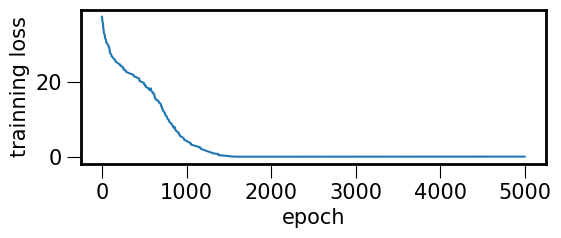

In [7]:
plt.figure(figsize=(6,2))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("trainning loss")
plt.show()

In [10]:
# example of performing 5-fold CV on all sessions

start_time = time.time()

R = 2 # rank
d = 0 # half window size
n_epochs = 5000

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

Us, Vs, metrics = {}, {}, {}
for pid in pids:
    
    print(f"start cross validation on session {pid[:8]} ..")
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    
    U_per_fold, V_per_fold, metrics_per_fold = [], [], []
    for fold_idx, (train, test) in enumerate(skf.split(X, Y)):
        
        print(f"start training on fold {fold_idx+1} ..")
        train_X, test_X = X[train], X[test]
        train_Y, test_Y = Y[train], Y[test]

        rrm = Reduced_Rank_Model(
            n_units=C, 
            n_t_bins=T, 
            rank=R, 
            half_window_size=d
        )

        # training
        rrm, train_losses = train_single_task(
            model=rrm,
            train_dataset=(train_X, train_Y),
            test_dataset=(test_X, test_Y),
            loss_function=torch.nn.BCELoss(),
            learning_rate=1e-3,
            weight_decay=1e-1,
            n_epochs=5000,
        )

        # eval
        test_U, test_V, test_metrics = model_eval(
            rrm, 
            train_dataset=(train_X, train_Y),
            test_dataset=(test_X, test_Y),
            behavior="choice"
        )
        U_per_fold.append(test_U)
        V_per_fold.append(test_V)
        metrics_per_fold.append(test_metrics)
        
    Us.update({pid: U_per_fold})
    Vs.update({pid: V_per_fold})
    metrics.update({pid: metrics_per_fold})

end_time = time.time()
print(f"time spent: {end_time - start_time: .3f} seconds")

start cross validation on session dab512bd ..
start training on fold 1 ..
Epoch [500/5000], Loss: 9.55117127698448
Epoch [1000/5000], Loss: 4.161833464803211
Epoch [1500/5000], Loss: 0.23385080706614642
Epoch [2000/5000], Loss: 0.07007899482504995
Epoch [2500/5000], Loss: 0.08028334416338805
Epoch [3000/5000], Loss: 0.08391636948155698
Epoch [3500/5000], Loss: 0.07894330709453648
Epoch [4000/5000], Loss: 0.07367179077596314
Epoch [4500/5000], Loss: 0.07166727946982367
Epoch [5000/5000], Loss: 0.07098950970622583
train accuracy: 0.991 auc: 0.906
test accuracy: 0.906 auc: 0.965
start training on fold 2 ..
Epoch [500/5000], Loss: 14.405160891272267
Epoch [1000/5000], Loss: 3.52378062724947
Epoch [1500/5000], Loss: 0.13427827038432957
Epoch [2000/5000], Loss: 0.0843561400871801
Epoch [2500/5000], Loss: 0.07573033472152049
Epoch [3000/5000], Loss: 0.07361202383705823
Epoch [3500/5000], Loss: 0.07283194495779037
Epoch [4000/5000], Loss: 0.07162597154649555
Epoch [4500/5000], Loss: 0.07025450

In [11]:
metrics_dict = {}
for pid in pids:
    metrics_dict.update({pid: np.mean(metrics[pid], 0)})
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.columns = ["accuracy", "auc"]
metrics_df

,accuracy,auc
dab512bd-a02d-4c1f-8dbc-9155a163efc0,0.90566,0.960568


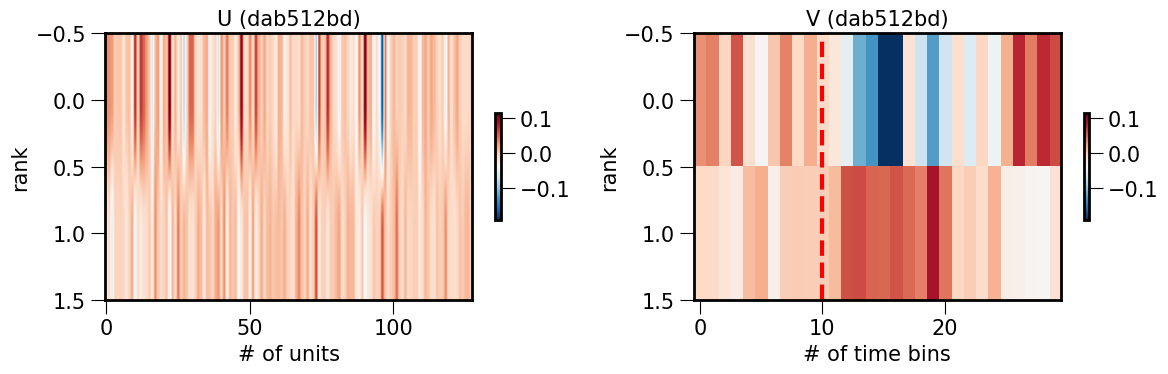

In [12]:
Us_plot, Vs_plot = [], []
for pid in pids:
    # average U and V across trials
    Us_plot.append(np.array(Us[pid]).mean(0))
    Vs_plot.append(np.array(Vs[pid]).mean(0).squeeze().T)
u_min, u_max = np.min(np.concatenate(Us_plot)), np.max(np.concatenate(Us_plot))
v_min, v_max = np.min(np.concatenate(Vs_plot)), np.max(np.concatenate(Vs_plot))
c_min, c_max = np.min([u_min, v_min]), np.max([u_max, v_max])
    
for pid_idx, pid in enumerate(pids):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
    heatmap1 = ax1.imshow(Us_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=c_min, vmax=c_max)
    heatmap2 = ax2.imshow(Vs_plot[pid_idx].T, aspect="auto", cmap="RdBu_r", vmin=c_min, vmax=c_max)
    ax2.axvline(x=10, c="red", linestyle="--", linewidth=3)
    cbar = fig.colorbar(heatmap1, ax=ax1, shrink=0.4)
    cbar = fig.colorbar(heatmap2, ax=ax2, shrink=0.4)
    ax1.set_ylabel("rank")
    ax1.set_xlabel("# of units")
    ax1.set_title(f"U ({pid[:8]})")
    ax2.set_ylabel("rank")
    ax2.set_xlabel("# of time bins")
    ax2.set_title(f"V ({pid[:8]})")
    plt.tight_layout()